In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy import signal, fftpack
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Raw IMS Data, Run #2
At the end of run 2, an outer race failure was observed on bearing 1.

In [2]:
col_names = ["b1_ch1", "b2_ch2", "b3_ch3", "b4_ch4"]

df = pd.read_csv("2004.02.12.10.42.39", sep="\t", names=col_names)
df.head()

,b1_ch1,b2_ch2,b3_ch3,b4_ch4
0,-0.088,-0.127,0.154,0.022
1,0.022,-0.178,-0.073,-0.022
2,-0.015,-0.066,-0.259,-0.056
3,-0.083,0.122,-0.005,-0.073
4,-0.056,-0.029,0.073,0.007


In [4]:
# save only b1_ch1 to a new csv file
df[["b1_ch1"]].to_csv("run2_b1_ch1.csv", index=False)


# Load only b1_ch1 from CSV
At the end of run 2, an outer race failure was observed on bearing 1.

We will load a sample from the very beginning of the run.

In [6]:
# load "run2_b1_ch1.csv"
df = pd.read_csv("run2_b1_ch1.csv")
df.head()

,b1_ch1
0,-0.088
1,0.022
2,-0.015
3,-0.083
4,-0.056


In [11]:
# functions to create an fft from the signal and a nice plot

def create_fft(
    df, y_name="b2_ch3", sample_freq=20480.0, window="hamming", beta=8.0
) -> Tuple[np.array, np.array]:
    """Create FFT plot from a pandas dataframe of signals


    Parameters
    ===========
    df : Pandas dataframe
        Signal that is being normalized

    y_name : str
        Signal name (column name from dataframe) that will be used to generate
        the FFT

    sample_freq : float
        Sampling frequency used to collect the signal

    window : str --> 'hamming' else assumed 'kaiser'
        Chose either the hamming or kaiser windowing function

    beta : float
        Used to determine shape of kaiser function. See scipy documentation
        for additional details. 14 is good to start with.

    Returns
    ===========
    x : ndarray
        Time (likely in seconds). Necessary for plotting time domain signals

    y : ndarray
        Time-domain signal (for example, the acceleration)

    xf : ndarray
        Frequency (likely in Hz). Necessary for plotting the frequency domain

    yf : ndarry
        Amplitude of FFT.

    """

    y = df[y_name].to_numpy(dtype="float64")  # convert to a numpy array
    x = np.arange(0, df.shape[0], dtype="float64") / (sample_freq)

    # parameters for plot
    T = 1.0 / sample_freq  # sample spacing
    N = len(y)  # number of sample points

    # do some preprocessing of the current signal
    y_detrend = y - np.mean(y)
    y_detrend = signal.detrend(y_detrend, type="constant")  # detrended signal

    if window == "hamming":
        y_detrend *= np.hamming(
            N
        )  # apply a hamming window. Why? https://dsp.stackexchange.com/a/11323
    else:
        y_detrend *= np.kaiser(len(y_detrend), beta)

    # FFT on time domain signal
    yf = fftpack.rfft(y_detrend)
    yf = 2.0 / N * np.abs(yf[: int(N / 2.0)])
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2) / 2

    return x, y, xf, yf


def create_time_frequency_plot(
    x, y, xf, yf, save_plot=False, save_name="time_freq_domain.svg", dpi=150
):
    """Create a time domain and frequency domain plot.

    Parameters
    ===========
    x : ndarray
        Time (likely in seconds). Necessary for plotting time domain signals

    y : ndarray
        Time-domain signal (for example, the acceleration)

    xf : ndarray
        Frequency (likely in Hz). Necessary for plotting the frequency domain

    yf : ndarry
        Amplitude of FFT.

    save_plot : boolean
        True or False, whether to save the plot to file

    save_name : str
        If saving the plot, what is the name? Can be a string and/or path

    dpi : int
        dpi of saved image, if applicable

    Returns
    ===========
    Saves and/or shows a plot.

    """

    # setup the seaborn plot
    sns.set(font_scale=1.1, style="whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)
    fig.tight_layout(pad=5.0)

    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

    # plot time domain signal
    axes[0].plot(x, y, marker="", label="Best model", color=pal[3], linewidth=0.8)
    axes[0].set_title("Time Domain", fontdict={"fontweight": "normal"})
    axes[0].set_xlabel("Time (seconds)")
    axes[0].set_ylabel("Acceleration (g)")

    # plot the frequency domain signal
    axes[1].plot(xf, yf, marker="", label="Best model", color=pal[3], linewidth=0.8)
    axes[1].set_title("Frequency Domain", fontdict={"fontweight": "normal"})
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Amplitude")
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    # clean up the sub-plots to make everything pretty
    for ax in axes.flatten():
        ax.yaxis.set_tick_params(labelleft=True, which="major")
        ax.grid(False)

    if save_plot:
        plt.savefig(save_name, dpi=dpi, bbox_inches="tight")

    else:
        plt.show()

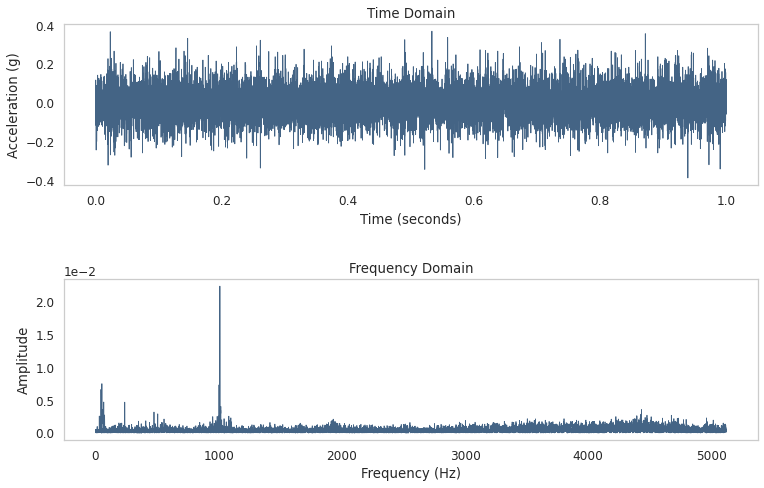

In [13]:
# create fft
x, y, xf, yf = create_fft(df, y_name='b1_ch1', sample_freq=20480.0, window='kaiser', beta=3)

# plot
create_time_frequency_plot(x, y, xf, yf, save_plot=False)

In their textbook, "Analysis of Time Series Structure: SSA and Related Techniques", Golyandina et al. discuss the process of applying singular value decomposition (SVD) to a time series. This method is called signular spectrum analysis (SSA).

Here, we'll explore the SSA method in more detail by applying it to the time series of the bearing.